## BBC Experiment [Part 5 - Cleaned Basic Segmentation Bro]

In [3]:
from fastai.vision import load_learner

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [9]:
path=Path('../data/bbc_train')

In [10]:
path.ls()

[PosixPath('../data/bbc_train/train.json'),
 PosixPath('../data/bbc_train/train_classification_labels.csv'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/train_masks'),
 PosixPath('../data/bbc_train/train')]

In [11]:
fnames = get_image_files(path/'train')
fnames[:3]

[PosixPath('../data/bbc_train/train/P2050886.jpg'),
 PosixPath('../data/bbc_train/train/P2050729.jpg'),
 PosixPath('../data/bbc_train/train/P2050513.jpg')]

In [12]:
lbl_names = get_image_files(path/'train_masks')
lbl_names[:3]

[PosixPath('../data/bbc_train/train_masks/P2050393.png'),
 PosixPath('../data/bbc_train/train_masks/P2050807.png'),
 PosixPath('../data/bbc_train/train_masks/P2050940.png')]

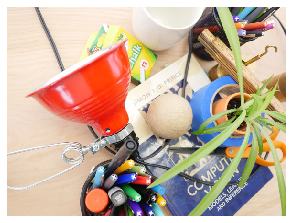

In [13]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [14]:
def get_y_fn(x): return path/'train_masks'/(x.stem + '.png')
classes = array(['background', 'brick', 'ball', 'cylinder'])

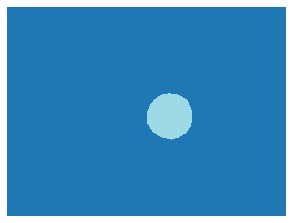

In [15]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [16]:
unique(mask.data)

array([0, 2])

In [17]:
src = (SegmentationItemList.from_folder(path/'train')
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))

In [18]:
data = (src.transform(get_transforms(), tfm_y=True, size=(256,256))
        .databunch(bs=16)
        .normalize(imagenet_stats))

In [19]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc_train/train;

Valid: LabelList (188 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc_train/train;

Test: None

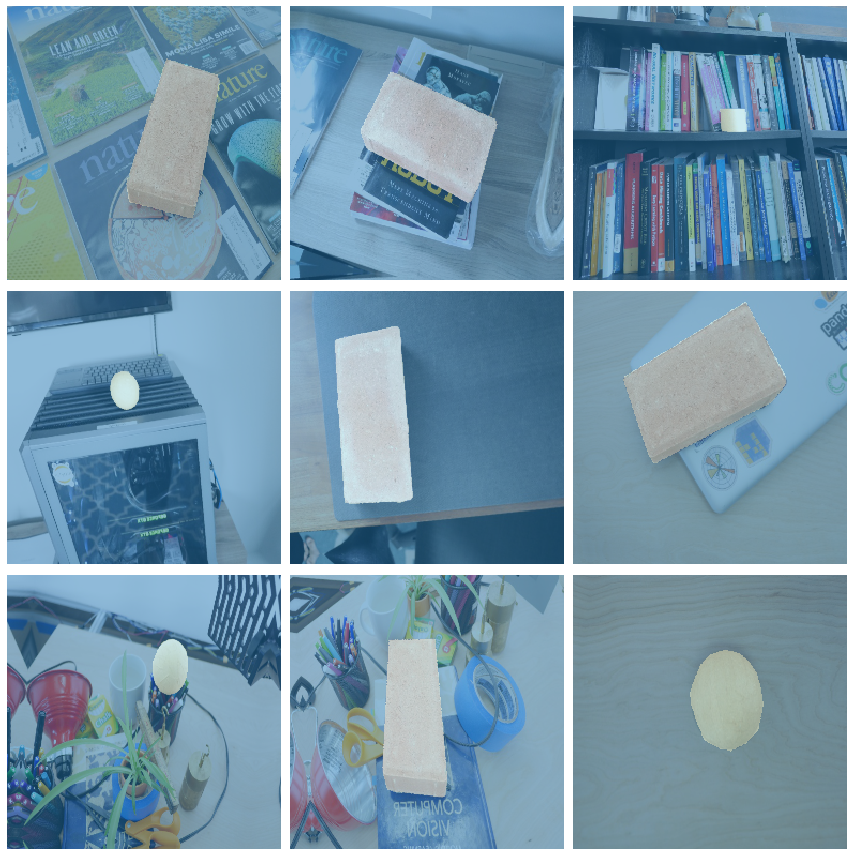

In [20]:
data.show_batch(3, figsize=(12,12))

- BatchNorm2d          [512, 8, 8]
- How can we build this up back to a full image?
- In my lecture, I should be able to borrow some from my GAN lecture on **transposed convolutions**: https://github.com/stephencwelch/dl-workshop/blob/master/generative_adversarial_networks/Generative%20Adversarial%20Networks.ipynb


In [23]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.ReLU(inplace = True), 
        nn.BatchNorm2d(nf))

In [24]:
custom_head=nn.Sequential(conv_trans(512, 256), 
                          conv_trans(256, 128),
                          conv_trans(128, 64),
                          conv_trans(64, 32), 
                          nn.ConvTranspose2d(32, 4, kernel_size=4, bias=False, stride=2, padding = 1))

In [25]:
def pixel_accuracy(yhat, y):
    y_=y.squeeze(dim=1)
    yhat_=yhat.argmax(dim=1)
    return (y_==yhat_).sum().float()/y.numel()

In [26]:
learn=cnn_learner(data, models.resnet18, custom_head=custom_head, metrics=pixel_accuracy)

In [27]:
learn.freeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


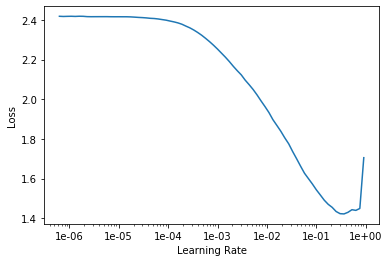

In [29]:
learn.recorder.plot()

In [30]:
lr=1e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.960356,0.290019,0.937841,00:15
1,0.407153,0.160034,0.956345,00:14
2,0.223215,0.105579,0.962371,00:14
3,0.154326,0.104257,0.962693,00:14


In [31]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


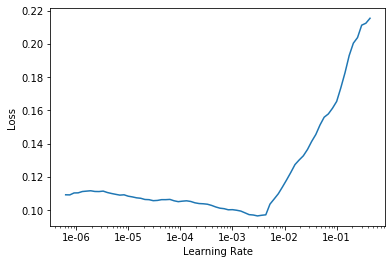

In [33]:
learn.recorder.plot()

In [34]:
lr=1e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.107587,0.094461,0.965358,00:15
1,0.094445,0.084088,0.968524,00:15
2,0.084868,0.071273,0.972188,00:15
3,0.076648,0.065767,0.974068,00:14
4,0.071969,0.061085,0.975941,00:15
5,0.066589,0.057804,0.977232,00:15
6,0.064259,0.056823,0.977441,00:15
7,0.062339,0.056881,0.977468,00:15


In [35]:
denorm=learn.data.denorm

In [42]:
with torch.no_grad():
    x,y = next(iter(learn.data.valid_dl))
    yhat = to_np(learn.model(x))
    x=denorm(x)

In [43]:
x.shape, y.shape, yhat.shape

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 1, 256, 256]),
 (16, 4, 256, 256))

In [44]:
x.dtype

torch.float32

In [38]:
yhat=yhat.argmax(1)

In [39]:
def blend_image_mask(im, mask, alpha=0.7):
    im_mask=np.zeros((im.shape[1], im.shape[2], 3), dtype='float32')
    for j in range(3): im_mask[:,:,j]=im.mean(axis=0)
    for j in range(1, 4):
        im_mask[mask==j] = alpha*im_mask[mask==j] + (1-alpha)*np.array([float(i==(j-1)) for i in range(3)])
    return im_mask

In [40]:
def make_legend():
    custom_lines = [Line2D([0], [0], color='r', lw=2, alpha=0.5),
                    Line2D([0], [0], color='g', lw=2, alpha=0.5),
                    Line2D([0], [0], color='b', lw=2, alpha=0.5)]

    legend(custom_lines, ['Brick', 'Ball', 'Cylinder'])

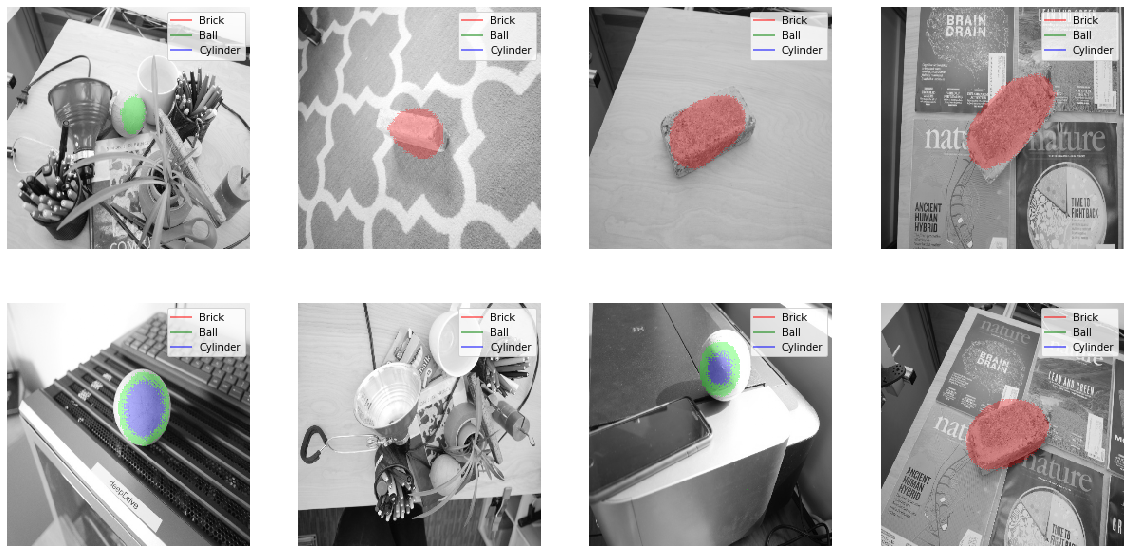

In [41]:
fig=figure(0, (20, 10))

for i in range(8):
    fig.add_subplot(2,4,i+1)
    im_mask=blend_image_mask(x[i], yhat[i])
    imshow(im_mask); axis('off'); make_legend()

---

In [51]:
from fastai.vision import *

In [47]:
x.shape

torch.Size([16, 3, 256, 256])

In [45]:
from fastai.vision import normalize

In [49]:
normalize(x, imagenet_stats)

TypeError: normalize() missing 1 required positional argument: 'std'

In [59]:
learn.data

In [66]:
learn.data.valid_ds.items[0]

PosixPath('../data/bbc_train/train/P2050814.jpg')

In [68]:
im=open_image(learn.data.valid_ds.items[0])

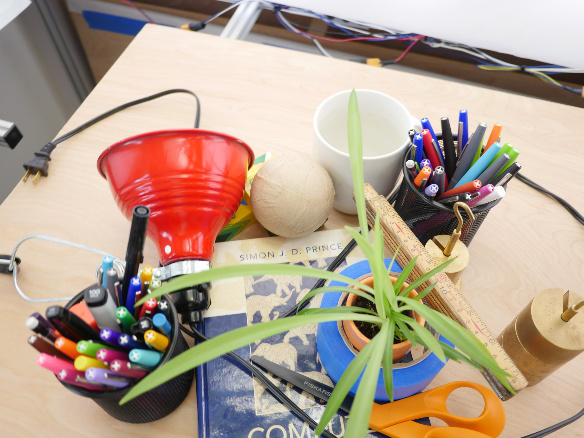

In [70]:
im

(array([ 24523.,  54124.,  54263.,  52712.,  64213.,  64686.,  68159.,  86472., 160552., 137672.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ], dtype=float32),
 <a list of 10 Patch objects>)

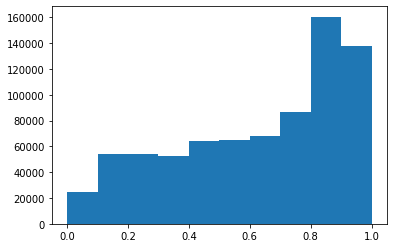

In [78]:
hist(im.data.numpy().ravel())

In [85]:
x_norm=normalize(x, torch.tensor(imagenet_stats[0]), torch.tensor(imagenet_stats[1]))

(array([ 41328., 154801., 234151., 266784., 287699., 357379., 587441., 675875., 380226., 160044.]),
 array([-2.117904, -1.642114, -1.166323, -0.690533, -0.214742,  0.261048,  0.736838,  1.212629,  1.688419,  2.16421 ,
         2.64    ], dtype=float32),
 <a list of 10 Patch objects>)

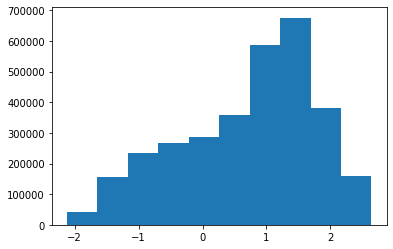

In [87]:
hist(x_norm.numpy().ravel())

In [88]:
learn.data.norm

functools.partial(<function _normalize_batch at 0x7ff8fdc617b8>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)

In [95]:
learn.data.stats[0]

[0.485, 0.456, 0.406]

In [93]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [94]:
torch.tensor(learn.data.stats)

tensor([[0.4850, 0.4560, 0.4060],
        [0.2290, 0.2240, 0.2250]])

In [96]:
x_norm=normalize(x, torch.tensor(learn.data.stats[0]), torch.tensor(learn.data.stats[1]))

(array([ 41328., 154801., 234151., 266784., 287699., 357379., 587441., 675875., 380226., 160044.]),
 array([-2.117904, -1.642114, -1.166323, -0.690533, -0.214742,  0.261048,  0.736838,  1.212629,  1.688419,  2.16421 ,
         2.64    ], dtype=float32),
 <a list of 10 Patch objects>)

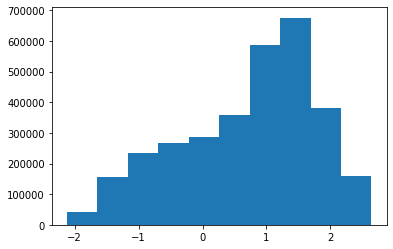

In [97]:
hist(x_norm.numpy().ravel())

In [113]:
bbox=np.random.rand(4)

In [119]:
bbox[0]*=255

In [120]:
bbox

array([13.341009,  0.083008,  0.094915,  0.65116 ])

In [138]:
np.random.randint(low=0, high=4, size=(255, 255))

array([[3, 2, 1, 3, ..., 2, 0, 0, 1],
       [1, 3, 3, 3, ..., 3, 0, 2, 3],
       [0, 0, 0, 1, ..., 1, 1, 2, 1],
       [2, 1, 2, 2, ..., 2, 1, 3, 1],
       ...,
       [2, 0, 1, 2, ..., 0, 1, 3, 2],
       [1, 2, 1, 3, ..., 1, 0, 3, 1],
       [0, 3, 3, 3, ..., 1, 3, 1, 1],
       [2, 0, 3, 3, ..., 0, 3, 1, 0]])

In [72]:
preds=learn.predict(im)

In [73]:
len(preds)

3

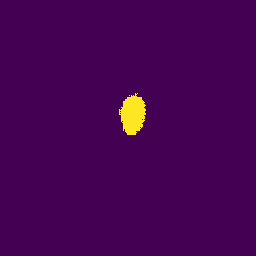

In [74]:
preds[0]

In [76]:
preds[1].shape

torch.Size([1, 256, 256])

In [77]:
preds[2].shape

torch.Size([4, 256, 256])

---

## Unet for comparison!

In [51]:
learn2=unet_learner(data, models.resnet18, metrics=pixel_accuracy)

In [52]:
learn2.freeze()

In [53]:
learn2.lr_find()

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

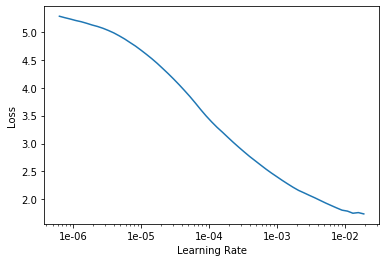

In [79]:
learn2.recorder.plot()

In [54]:
lr=1e-4
learn2.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.429264,0.156954,0.947262,01:17
1,0.191191,0.080478,0.975266,01:09
2,0.104421,0.048497,0.984832,01:09
3,0.063750,0.040329,0.986619,01:09


In [55]:
learn2.unfreeze()

In [82]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


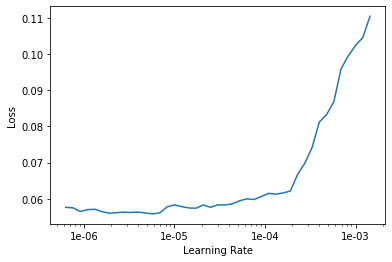

In [83]:
learn2.recorder.plot()

In [56]:
lr=1e-5
learn2.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.037782,0.036721,0.987524,01:11
1,0.035218,0.032550,0.988374,01:11
2,0.031922,0.031729,0.988692,01:11
3,0.029804,0.032229,0.988844,01:11


In [ ]:
lr=1e-5
learn2.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.026647,0.031326,0.989065,01:11
1,0.027070,0.028643,0.989787,01:11
2,0.025731,0.026436,0.990534,01:11
3,0.024287,0.025076,0.990898,01:11
4,0.022648,0.023142,0.991503,01:11
5,0.020983,0.022824,0.991535,01:11
6,0.020133,0.022102,0.991817,01:11


In [63]:
x,y = learn2.data.one_batch()

In [ ]:
with torch.no_grad():
    yhat=learn2.model(x.to('cuda'))

In [ ]:
yhat.shape, yhat.device, yhat.dtype

In [ ]:
y.shape, y.device, y.dtype

In [ ]:
fig=figure(0, (20, 10))

for i in range(8):
    fig.add_subplot(2,4,i+1)
    im_mask=blend_image_mask(x[i], yhat[i])
    imshow(im_mask); axis('off'); make_legend()